In [1]:
import datetime
import time
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.window import Window
import math

from pyspark.ml.recommendation import ALS

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('recommendations-DEV-MIND').getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/30 22:16:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from typing import Dict, List
from numpy.typing import ArrayLike
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.stats import entropy

import numpy as np
import math

def harmonic_number(n):
    """Returns an approximate value of n-th harmonic number.
    http://en.wikipedia.org/wiki/Harmonic_number
    """
    # Euler-Mascheroni constant
    gamma = 0.57721566490153286060651209008240243104215933593992
    return gamma + math.log(n) + 0.5 / n - 1.0 / (12 * n**2) + 1.0 / (120 * n**4)

def cosine_distances(X: ArrayLike) -> np.ndarray:
    """Implementation of the pairwice cosine similarity function
    Args:
        X: {array-like, sparse matrix} of shape (n_samples_X, n_features)
    Returns:
        distance matrix: ndarray of shape (n_samples_X, n_samples_Y)
    """
    distances = pdist(X, metric="cosine")
    return squareform(distances)

def compute_normalized_distribution(
    a: List[str],
    weights: List[float] = None,
    distribution: Dict[str, float] = None,
) -> Dict[str, float]:
    """
    Compute a normalized weigted distribution for a list of items that each can have a single representation assigned.

    Args:
        a (np.ndarray[str]): a list/array of items representation.
        weights (ArrayLike[float], optional): weights to assign each element in a. Defaults to None.
            * Following yields: len(weights) == len(a)
        distribution (Dict[str, float], optional): dictionary to assign the distribution values, if None it will be generated as {}. Defaults to None.
            * Use case; if you want to add distribution values to existing, one can input it.

    Returns:
        Dict[str, float]: dictionary with normalized distribution values

    >>> a = np.array(["a", "b", "c", "c"])
    >>> weights = np.array([1 / rank / harmonic_number(len(a)) for rank in range(1, len(a) + 1)])
    >>> compute_distribution(a, weights=weights)
        {'a': 0.4799997900047559, 'b': 0.23999989500237795, 'c': 0.2799998775027743}
    >>> compute_distribution(a)
        {'a': 0.25, 'b': 0.25, 'c': 0.5}
    """

    n_elements = len(a)

    distr = {} if not distribution else distribution
    weights = weights if weights else list([1 / n_elements for rank in range(1, n_elements + 1)])
    for item, weight in zip(a, weights):
        distr[item] = weight + distr.get(item, 0.0)
    return distr

def compute_normalized_distribution_multiple_categories(
    a: List[List[str]],
    weights: List[float] = None,
    distribution: Dict[str, float] = None,
) -> Dict[str, float]:
    """
    Compute a normalized weigted distribution for a list of items that each can have multiple representation assigned.
    For instance, a list of news articles that each can have multiple categoies, e.g. 'politics' + 'economy' OR 'entertainment' + 'sport'.

    Args:
        a (List[set[str]]): a list of sets of items representation.
        weights (ArrayLike[float], optional): weights to assign each set in the list. Defaults to None.
            * Following yields: len(weights) == len(a)
        distribution (Dict[str, float], optional): dictionary to assign the distribution values, if None it will be generated as {}. Defaults to None.
            * Use case; if you want to add distribution values to existing, one can input it.
    Returns:
        Dict[str, float]: dictionary with normalized distribution values
    >>> a = [['a', 'x'], ['b', 'c', 'x'], ['c', 'a', 'y', 'x', 'q', 't'], ['c', 'b']]
    >>> weights = np.array([1 / rank / harmonic_number(len(a)) for rank in range(1, len(a) + 1)])
    >>> compute_distribution_multiple_categories(a, weights=weights)
    """
    n_elements = len(a)

    distr = {} if not distribution else distribution
    weights = weights if weights else list([1 / n_elements for rank in range(1, n_elements + 1)])
    for item, weight in zip(a, weights):
        for cat in set(item):
            distr[cat] = weight + distr.get(cat, 0.0)
    norm_ = sum(distr.values())
    return {key: val / norm_ for key, val in distr.items()}

In [3]:
from scipy.spatial import distance

def opt_merge_max_mappings(dict1, dict2):
    """ Merges two dictionaries based on the largest value in a given mapping.
    Parameters
    ----------
    dict1 : Dict[Any, Comparable]
    dict2 : Dict[Any, Comparable]
    Returns
    -------
    Dict[Any, Comparable]
        The merged dictionary
    """
    # we will iterate over `other` to populate `merged`
    merged, other = (dict1, dict2) if len(dict1) > len(dict2) else (dict2, dict1)
    merged = dict(merged)

    for key in other:
        if key not in merged or other[key] > merged[key]:
            merged[key] = other[key]
    return merged

def avoid_distribution_misspecification(s: Dict, q: Dict, alpha=0.001) -> Dict:
    """ """
#     merged_dic = np.unique(list(s) + list(q)).tolist()
    merged_dic = opt_merge_max_mappings(s, q)
    
    for key in sorted(merged_dic):
        q_score = q.get(key, 0.0)
        s_score = s.get(key, 0.0)
        s[key] = (1 - alpha) * s_score + alpha * q_score
        q[key] = (1 - alpha) * q_score + alpha * s_score
    # Sort
    q = {key: q[key] for key in sorted(q.keys())}
    s = {key: s[key] for key in sorted(s.keys())}
    return s, q

def user_level_RADio_categorical(
    user_recommendations: List[str],
    users_context: List[str],
    user_rec_weights: List[float] = [],
    users_context_weights: List[float] = [],
) -> float:
    """_summary_
    Args:
        user_recommendations (np.ndarray[str]): _description_
        users_context (np.ndarray[str]): _description_
        user_rec_weights (np.ndarray[float]): _description_
        users_context_weights (np.ndarray[float]): _description_
    Returns:
        float: _description_
    len(users_context) == len(users_context_weights)
    len(user_recommendations) == len(user_rec_weights)
    """
    q = compute_normalized_distribution(user_recommendations, weights=user_rec_weights)
    p = compute_normalized_distribution(users_context, weights=users_context_weights)
    qq, pp = avoid_distribution_misspecification(q, p)
    return float(distance.jensenshannon(list(qq.values()), list(pp.values()), base=2))
  
def user_level_RADio_multicategorical(
    user_recommendations: List[List[str]],
    users_context: List[List[str]],
    user_rec_weights: List[float] = [],
    users_context_weights: List[float] = [],
) -> float:
    """_summary_
    Args:
        user_recommendations (np.ndarray[np.ndarray[str]]): _description_
        users_context (np.ndarray[np.ndarray[str]): _description_
        user_rec_weights (np.ndarray[float]): _description_
        users_context_weights (np.ndarray[float]): _description_
    Returns:
        float: _description_
    len(users_context) == len(users_context_weights)
    len(user_recommendations) == len(user_rec_weights)
    """
    q = compute_normalized_distribution_multiple_categories(user_recommendations, weights=user_rec_weights)
    p = compute_normalized_distribution_multiple_categories(users_context, weights=users_context_weights)
    qq, pp = avoid_distribution_misspecification(q, p)
    return float(distance.jensenshannon(list(qq.values()), list(pp.values()), base=2))


In [4]:
def read_behavior(path):
    myschema = StructType([
        StructField('index', IntegerType(), True),
        StructField('user', StringType(), True),
        StructField('datetime', StringType(), True),
        StructField('behavior_string', StringType(), True),
        StructField('preselection_string', StringType(), True)
    ])
    
    behaviors_presel_df = spark.read.csv(path, sep="\t", schema=myschema)#.drop('index')
    behaviors_presel_df = behaviors_presel_df.withColumn('behavior_array', F.split(F.col('behavior_string'),' ')).drop('behavior_string')
    behaviors_presel_df = behaviors_presel_df.withColumn('preselection_array', F.split(F.col('preselection_string'),' ')).drop('preselection_string')
    behaviors_presel_df = behaviors_presel_df.withColumn('pool_array', F.udf(lambda x: [i.split('-')[0] for i in x], ArrayType(StringType()))(F.col('preselection_array')))
                                           
    
    behaviors_df = behaviors_presel_df.select('user', 'behavior_array', 'index')
    behaviors_df = behaviors_df.withColumn('item', F.explode('behavior_array')).drop('behavior_array')
    behaviors_df = behaviors_df.withColumn('item_id', F.split(F.col('item'),'N').getItem(1).cast(IntegerType())).drop('item')
    behaviors_df = behaviors_df.withColumn('rating', F.lit(1).cast(IntegerType()))
    
    preselection_df = behaviors_presel_df.select('user', 'preselection_array', 'index')
    preselection_df = preselection_df.withColumn('item', F.explode('preselection_array')).drop('preselection_array')
    preselection_df = preselection_df.withColumn('success', F.split(F.col('item'),'-').getItem(1).cast(IntegerType()))
    preselection_df = preselection_df.withColumn('item_id', 
                                     F.split(F.split(F.col('item'),'-').getItem(0),'N').getItem(1).cast(IntegerType()))#.drop('item')
    
    return behaviors_presel_df, behaviors_df, preselection_df

def get_personas(str_list, y):
    val = []
    if str_list is not None:
      a_str_split_p = str_list.split("PERSON")
      a_str_split_o = str_list.split("ORG")
      persons = [i.split("'text': '")[-1].split("',")[0] for i in a_str_split_p[:-1]]
      orgs = [i.split("'text': '")[-1].split("',")[0] for i in a_str_split_o[:-1]]
      val = persons + orgs
    return val 
  

def read_articles(path):
    myschema = StructType([
                StructField('_c0', StringType(), True),
                StructField('newsid', StringType(), True),
                StructField('title', StringType(), True),
                StructField('category', StringType(), True),
                StructField('subcategory', StringType(), True),
                StructField('cat_subcat', ArrayType(StringType()), True),
                StructField('abstract', StringType(), True),
                StructField('publication_date', StringType(), True),
                StructField('url', StringType(), True)
            ])
    articles_df = spark.read.json(path, schema=myschema)
    print('Nr of unique articles', articles_df.select('newsid').distinct().count())
    return articles_df

def get_top_rec_ids_array(pred_df, behaviors_presel_df, top_k):
    # Create a df with one row per user that contains only the top_k recommendations, that is the newsid and not the position of the preselection
    pred_df = pred_df.filter(F.col('size_list') >= top_k)
    pred_preselection_df = pred_df.join(behaviors_presel_df.select('index', 'user', 'preselection_array'), 'index')
    pred_preselection_df = pred_preselection_df.withColumn('pred_slice_id', F.udf(lambda x,y: [str(y[indx]).split('-')[0] for indx, ele in enumerate(x) if ele <= top_k],
                                                                                  ArrayType(StringType()))(F.col('pred_rank'), F.col('preselection_array')))
    pred_preselection_df = pred_preselection_df.drop('preselection_array').drop('pred_rank')
    return pred_preselection_df
  
def read_predictions(path_predictions, behaviors_presel_df, top_k, algo):
    pred_df = spark.read.json(path_predictions)
    pred_df = pred_df.withColumn('size_list', F.size('pred_rank'))
    pred_df = pred_df.withColumnRenamed('impr_index','index')
    pred_df = pred_df.withColumn('algo', F.lit(algo))
    
    pred_preselection_df = get_top_rec_ids_array(pred_df, behaviors_presel_df, top_k = 2*top_k)
    return pred_df, pred_preselection_df


In [5]:
def is_multilabel_based_on_dtype(df, column):
    dtype = None
    for i in df.dtypes:
        if i[0] == column:
           dtype = i[1]
    if dtype is not None and dtype == 'array<string>':
        return True
    return False

def mmr(n):
  return list([1 / rank / harmonic_number(n) for rank in range(1, n + 1)])

def get_cat(df, articles_df, column, cat_column, top_at, slice_col=False, show_unique_nr=False):
    df_exploded = df.select('*', F.posexplode(column).alias('rank', 'newsid'))\
                    .withColumn('rank', F.col('rank') + 1).drop(column)
    if show_unique_nr:
        print('Nr of articles:')
        print('df_exploded                     ', df_exploded.select('newsid').distinct().count())
        print('articles_df                     ', articles_df.select('newsid').distinct().count())
        temp2 = df_exploded.select('newsid').distinct().join(articles_df.select('newsid').distinct(), on='newsid', how='leftanti')
        print('df_exploded leftanti articles_df', temp2.select('newsid').distinct().count())
        temp3 = df_exploded.select('newsid').distinct().join(articles_df.select('newsid').distinct(), on='newsid', how='inner')
        print('df_exploded inner articles_df   ', temp3.select('newsid').distinct().count())
        
    df_cat = df_exploded.join(articles_df.select('newsid',cat_column).distinct(), 'newsid', how='inner')
    w = Window.partitionBy('index').orderBy('rank')
    df_cat = df_cat.withColumn('sorted_cat_list', F.collect_list(cat_column).over(w))\
                   .withColumn('sorted_newsid_list', F.collect_list('newsid').over(w))\
                   .groupby('index').agg(F.max('sorted_cat_list').alias('sorted_cat_list'),
                                                              F.max('sorted_newsid_list').alias('sorted_newsid_list'))
    df_cat = df_cat.join(df.drop(column), 'index')
    if slice_col:
        df_cat = df_cat.withColumn('sorted_cat_list', F.slice('sorted_cat_list', 1, top_at))
        df_cat = df_cat.withColumn('sorted_newsid_list', F.slice('sorted_newsid_list', 1, top_at))
        df_cat = df_cat.withColumn('size_cat_list', F.size('sorted_cat_list'))
#         print('removing {} rows which have less than {} items'.format(df_cat.filter(F.col('size_cat_list') < TOP_AT).count(), TOP_AT))
        df_cat = df_cat.filter(F.col('size_cat_list') == top_at)
    return df_cat

In [6]:
def get_classic_calibration(pred_preselection_df, articles_df, behaviors_presel_df, cat_column, top_at):
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True, show_unique_nr=False)
    
    df_cat_history = get_cat(behaviors_presel_df.select('index', 'user', 'behavior_array'), articles_df, 'behavior_array', cat_column, top_at, slice_col=False)
    df_cat_history = df_cat_history.selectExpr('index', 'user', 'sorted_cat_list as history_cat_list', 'sorted_newsid_list as history_newsid_list')
    
    df_rec_hist = df_cat.join(df_cat_history, ['index', 'user'], 'inner')
    
    is_multilabel = is_multilabel_based_on_dtype(articles_df, cat_column)
    df_calibration = df_rec_hist.withColumn('calibration', F.udf(lambda x,y: user_level_RADio_categorical(x,y,mmr(len(x))) if not is_multilabel
                                                                 else user_level_RADio_multicategorical(x,y,mmr(len(x))), DoubleType())\
                                                                 (F.col('sorted_cat_list'), F.col('history_cat_list')))
    return df_calibration

def get_classic_representation(pred_preselection_df, articles_df, behaviors_presel_df, cat_column, top_at):
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    
    df_cat_pool = get_cat(behaviors_presel_df.select('index', 'user', 'pool_array'), articles_df, 'pool_array', cat_column, top_at, slice_col=False)
    df_cat_pool = df_cat_pool.selectExpr('index', 'user', 'sorted_cat_list as pool_cat_list', 'sorted_newsid_list as pool_newsid_list')
    
    df_rec_pool = df_cat.join(df_cat_pool, ['index', 'user'], 'inner')
    
    is_multilabel = is_multilabel_based_on_dtype(articles_df, cat_column)
    df_representation = df_rec_pool.withColumn('representation', F.udf(lambda x,y: user_level_RADio_categorical(x,y,mmr(len(x))) if not is_multilabel
                                                                       else user_level_RADio_multicategorical(x,y,mmr(len(x))), DoubleType())\
                                                                       (F.col('sorted_cat_list'), F.col('pool_cat_list')))
    return df_representation

def get_classic_fragmentation(pred_preselection_df, articles_df, cat_column, top_at, sample_size=0.05):
    df_cat = get_cat(pred_preselection_df, articles_df, 'pred_slice_id', cat_column, top_at, slice_col=True)
    df_cat_cat = df_cat.crossJoin(df_cat.sample(sample_size)\
                                  .selectExpr('index as other_index', 'user as other_user', 'sorted_cat_list as rec_cat_list', 'sorted_newsid_list as rec_newsid'))
    df_cat_cat = df_cat_cat.filter(F.col('index') != F.col('other_index'))
    
    is_multilabel = is_multilabel_based_on_dtype(articles_df, cat_column)
    df_cat_cat = df_cat_cat.withColumn('fragmentation_detail', F.udf(lambda x,y: user_level_RADio_categorical(x,y,mmr(len(x))) if not is_multilabel
                                                                     else user_level_RADio_multicategorical(x,y,mmr(len(x))), DoubleType())\
                                                                     (F.col('sorted_cat_list'), F.col('rec_cat_list')))
    df_fragmentation = df_cat_cat.groupby('index', 'user', 'algo').agg(F.mean('fragmentation_detail').alias('fragmentation'))
    return df_fragmentation

In [7]:

def read_recommendations_and_calculate_metrics(articles_df, behaviors_presel_df, sufix, algos, top_at = 10, NR_BINS = 200):
    df_calibration_all = None
    df_representation_all = None
    df_fragmentation_all = None

    for algo in algos:
        PATH_PRED = 'recommendations/'+algo+'_pred_'+sufix+'.json'
        pred_df, pred_preselection_df = read_predictions(PATH_PRED, behaviors_presel_df, top_k = top_at, algo = algo)
#         print(algo)

        df_calibration = get_classic_calibration(pred_preselection_df, articles_df, behaviors_presel_df, 'category', top_at)\
                            .select('index','user','calibration','algo')
        if df_calibration_all is None:
            df_calibration_all = df_calibration
        else:
            df_calibration_all = df_calibration_all.unionByName(df_calibration)

        df_representation = get_classic_representation(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_subcat', top_at)\
                              .select('index','user','representation','algo')
        if df_representation_all is None:
            df_representation_all = df_representation
        else:
            df_representation_all = df_representation_all.unionByName(df_representation)

        df_fragmentation = get_classic_fragmentation(pred_preselection_df, articles_df, 'cat_subcat', top_at, sample_size=0.02)\
                              .select('index','user','fragmentation','algo')
        if df_fragmentation_all is None:
            df_fragmentation_all = df_fragmentation
        else:
            df_fragmentation_all = df_fragmentation_all.unionByName(df_fragmentation)
#         print()
    
    df_calibration_all = df_calibration_all.withColumn('calibration_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('calibration')))
    calibration_agg_df = df_calibration_all.groupby('algo', 'calibration_bin').count()
    
    df_representation_all = df_representation_all.withColumn('representation_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('representation')))
    representation_agg_df = df_representation_all.groupby('algo', 'representation_bin').count()
    
    df_fragmentation_all = df_fragmentation_all.withColumn('fragmentation_bin', F.udf(lambda x: round(x*NR_BINS,0)/NR_BINS, DoubleType())(F.col('fragmentation')))
    fragmentation_agg_df = df_fragmentation_all.groupby('algo', 'fragmentation_bin').count()
    return df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df


In [8]:
sufix = 'small'
PATH_BEHAVIOURS = 'behaviors_'+sufix+'.tsv'
PATH_ARTICLES = 'articles_large_narrow.json'

articles_df = read_articles(path=PATH_ARTICLES)
behaviors_presel_df, behaviors_df, preselection_df = read_behavior(path=PATH_BEHAVIOURS)

df_calibration_all, calibration_agg_df, df_representation_all, representation_agg_df, df_fragmentation_all, fragmentation_agg_df = read_recommendations_and_calculate_metrics(articles_df, behaviors_presel_df, sufix = sufix, algos = ['lstur', 'pop', 'naml', 'npa', 'nrms'], top_at = 10, NR_BINS = 200)

Nr of unique articles 68392


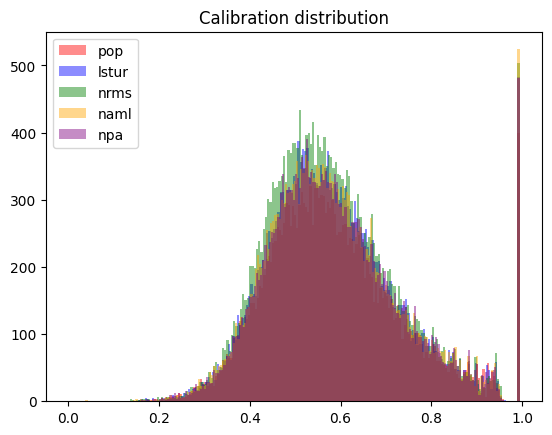

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
  
df = df_calibration_all.toPandas()
  
# plotting two histograms on the same axis
plt.hist(df.loc[(df["algo"] == "pop"), ["calibration"]], bins=200, alpha=0.45, color='red')
plt.hist(df.loc[(df["algo"] == "lstur"), ["calibration"]], bins=200, alpha=0.45, color='blue')
plt.hist(df.loc[(df["algo"] == "nrms"), ["calibration"]], bins=200, alpha=0.45, color='green')
plt.hist(df.loc[(df["algo"] == "naml"), ["calibration"]], bins=200, alpha=0.45, color='orange')
plt.hist(df.loc[(df["algo"] == "npa"), ["calibration"]], bins=200, alpha=0.45, color='purple')

plt.title("Calibration distribution")
  
plt.legend(['pop', 'lstur', 'nrms', 'naml', 'npa'])
  
plt.show()

In [ ]:
# df_calibration_all.groupby('algo').agg(F.mean('calibration').alias('mean_calibration'), 
#                                        F.stddev('calibration').alias('stddev_calibration')).show()

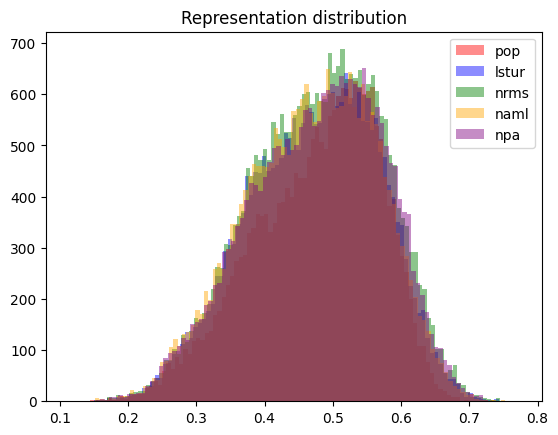

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_representation_all.toPandas()
  
# plotting two histograms on the same axis
plt.hist(df.loc[(df["algo"] == "pop"), ["representation"]], bins=100, alpha=0.45, color='red')
plt.hist(df.loc[(df["algo"] == "lstur"), ["representation"]], bins=100, alpha=0.45, color='blue')
plt.hist(df.loc[(df["algo"] == "nrms"), ["representation"]], bins=100, alpha=0.45, color='green')
plt.hist(df.loc[(df["algo"] == "naml"), ["representation"]], bins=100, alpha=0.45, color='orange')
plt.hist(df.loc[(df["algo"] == "npa"), ["representation"]], bins=100, alpha=0.45, color='purple')

plt.title("Representation distribution")
  
plt.legend(['pop', 'lstur', 'nrms', 'naml', 'npa'])
  
plt.show()

In [ ]:
# df_representation_all.groupby('algo').agg(F.mean('representation').alias('mean_representation'), 
#                                           F.stddev('representation').alias('stddev_representation')).show()

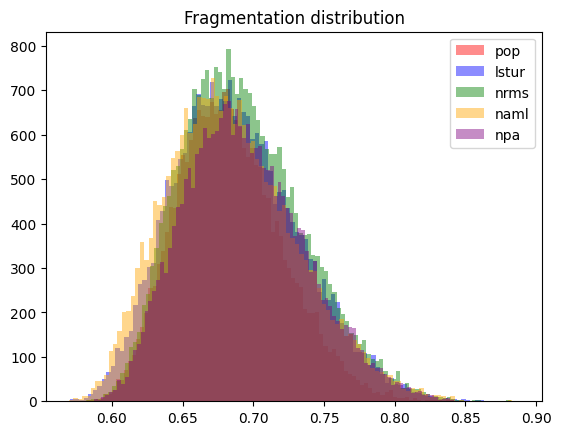

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_fragmentation_all.toPandas()
  
# plotting two histograms on the same axis
plt.hist(df.loc[(df["algo"] == "pop"), ["fragmentation"]], bins=100, alpha=0.45, color='red')
plt.hist(df.loc[(df["algo"] == "lstur"), ["fragmentation"]], bins=100, alpha=0.45, color='blue')
plt.hist(df.loc[(df["algo"] == "nrms"), ["fragmentation"]], bins=100, alpha=0.45, color='green')
plt.hist(df.loc[(df["algo"] == "naml"), ["fragmentation"]], bins=100, alpha=0.45, color='orange')
plt.hist(df.loc[(df["algo"] == "npa"), ["fragmentation"]], bins=100, alpha=0.45, color='purple')

plt.title("Fragmentation distribution")
  
plt.legend(['pop', 'lstur', 'nrms', 'naml', 'npa'])
  
plt.show()

In [ ]:
# display(df_fragmentation_all.groupby('algo').agg(F.mean('fragmentation').alias('mean_fragmentation'), F.stddev('fragmentation').alias('stddev_fragmentation')))

algo,mean_fragmentation,stddev_fragmentation
lstur,0.8051367747077504,0.03334955976549406
pop,0.7808469677567781,0.031611804226194036
naml,0.7886399536233348,0.036384301733478334
npa,0.7969852605739273,0.033223707022773774
nrms,0.7924785881139604,0.034227846507726103
